In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (ndarray): rotaion axis (normalized).
        theta (float): rotation angle in radian.

    Returns:
        - (ndarray) -- 3x3 rotation matrix.
    """
    K = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    I = np.eye(3)
    R = I + np.sin(theta) * K + (1.0 - np.cos(theta)) * np.dot(K, K)
    return R


def create_shift_tensor(ks, Rs):
    """
    Create shift tensors for all sites.

    Args:
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (list) -- shift tensors in each site.
    """
    k1, k2, k3, k4, k5, k6 = ks
    K = [[k1,k6,k5],[k6,k2,k4],[k5,k4,k3]]
    Ks = [R @ K @ R.T for R in Rs]
    return Ks


def nmr_shift(Ks, h):
    """
    Compute the NMR shift without the contributions from the quadrupolar interactions.

    Args:
        Ks (list): list of 3x3 shift tensors.
        h (ndarray): magnetic field.

    Returns:
        - (list) -- NMR shift for each K.
    """
    shift = [np.diag(h @ K @ h.T) for K in Ks]
    return shift


def compute_shift(n, s, ks, Rs):
    """
    Compute angle dependence of NMR shift.

    Args:
        n (list): rotation axis.
        s (list): starting vector.
        ks (list): components of K, (Kxx, Kyy, Kzz, Kyz, Kzx, Kxy).
        Rs (list): symmetry operations for each site.

    Returns:
        - (ndarray) -- angles.
        - (list) -- angle dependence of NMR shift around n axis.
        - (list) -- angle dependence of NMR shift around nxs axis.
    """
    theta = np.radians(range(181))

    n = np.array(n)
    n1 = n / np.linalg.norm(n)
    s = np.array(s)
    s = s / np.linalg.norm(s)
    n2 = np.cross(n1, s)
    h1 = np.array([rotation_matrix(n1, t) @ s for t in theta])
    h2 = np.array([rotation_matrix(n2, t) @ s for t in theta])

    Ks = create_shift_tensor(ks, Rs)

    shift1 = nmr_shift(Ks, h1)
    shift2 = nmr_shift(Ks, h2)

    return theta, shift1, shift2


def plot_data(theta, shift1, shift2):
    """
    Plot angle dependences.

    Args:
        theta (ndarray): angles.
        shift1 (list): angle dependence of NMR shift around n axis.
        shift2 (list): angle dependence of NMR shift around nxs axis.
    """
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
    axes.set_title("Knight shift of Te")
    axes.set_xlabel("Rotation angle [deg.]", fontsize=15)
    axes.set_ylabel("Knight shift [%]", fontsize=15)

    axes.set_xlim([0, 180])
    axes.grid()

    n_site = len(shift1)
    colors = ["blue", "green", "red"]
    theta = theta * 180/np.pi
    for site in range(n_site):
        axes.plot(theta, shift1[site]*100, "-", color=colors[site], label=f'$K_{site+1}$')
    for site in range(n_site):
        axes.plot(theta, shift2[site]*100, "--", color=colors[site], label=f'$K_{site+1}$')

    axes.legend()

    plt.autoscale(enable=True, axis='y')
    plt.show()


def save_data(filename, theta, shift):
    """
    Save data.

    Args:
        filename (str): filename.
        theta (ndarray): theta.
        shift (list): shift.
    """
    with open(filename, mode="w", encoding="utf-8") as f:
        header = " ".join(["# theta"] + [f"shift{i:02}" for i in range(len(shift))])
        print(header, file=f)
        for row in list(zip(theta,*shift)):
            s = " ".join([f"{i:.12e}" for i in row])
            print(s, file=f)


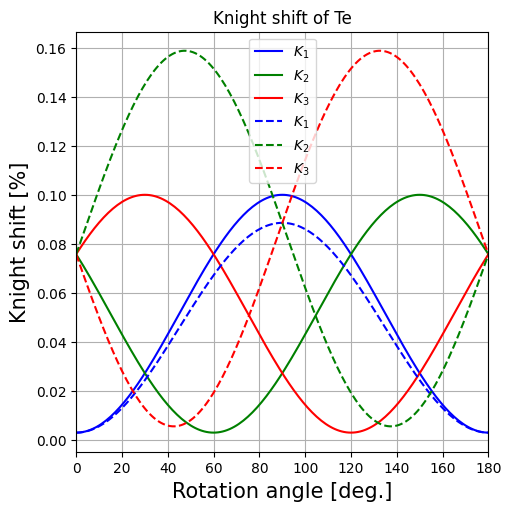

In [3]:
# In the case of Te. (Te1 is on y-bond).
ks = [8.860e-4 -8.572e-4, 8.860e-4 +1.146e-4, 8.860e-4, -8.830e-4, 0.0, 0.0]

E = np.eye(3)
C3 = rotation_matrix([0,0,1], 2.0*np.pi/3.0) # for Te2.
C3i = C3.T # for Te3.

Rs = [E, C3i, C3]

n = [0,0,1]
s = [1,0,0]
theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
plot_data(theta, shift1, shift2)

In [4]:
#n = [0.3,0.1,0.2]
#s = [0.1,0.2,0.3]
#theta, shift1, shift2 = compute_shift(n, s, ks, Rs)
#save_data("shift1.dat", theta, shift1)
#save_data("shift2.dat", theta, shift2)

# QtDraw の使用例

In [5]:
# QtDraw を使うため
from qtdraw.core.qtdraw_app import QtDraw
qtdraw = QtDraw()

In [6]:
# シフトテンソルを(x,y,z)の二次式で表現
def shift_tensor_str(K):
    v0, v1, v2, v3, v4, v5 = (K[0,0]+K[1,1]+K[2,2])/np.sqrt(3), (2*K[2,2]-K[0,0]-K[1,1])/np.sqrt(6), (K[0,0]-K[1,1])/np.sqrt(2), K[1,2]*np.sqrt(2), K[0,2]*np.sqrt(2), K[0,1]*np.sqrt(2)
    orb = f"({v0}) + ({v1})*(2z**2-x**2-y**2)/2 + ({v2})*(x**2-y**2)*sqrt(3)/2 + ({v3})*(y*z)*sqrt(3) + ({v4})*(z*x)*sqrt(3) + ({v5})*(x*y)*sqrt(3)"
    return orb

qtdraw.set_crystal("trigonal") # 三方晶
qtdraw.set_unit_cell({"a": 4.458,"b": 4.458, "c": 5.925}) # 単位格子のサイズ
qtdraw.set_axis()

x = 0.274
site = [[x,0,1/3], [-x,-x,0], [0,x,2/3]] # Te の3つのサイトの位置 (単位格子ベクトルの単位で)
bond = [[[-x,-x,0],[x,0,1/3]], [[x,0,1/3],[0,x,2/3]], [[0,x,2/3],[-x,-x,1]]] # ボンド (始点、終点)
Ks = create_shift_tensor(ks, Rs) # 各 Te 位置でのシフトテンソル (ks は1つめのTeサイトのシフトテンソル)


In [7]:
Kstr = [shift_tensor_str(i) for i in Ks] # 各シフトテンソルを2次式に
qtdraw.clear_data() # 前の描画を消す
for k, i, b in zip(Kstr, site, bond):
    b = np.asarray(b)
    c, v = (b[0]+b[1])/2, b[1]-b[0]
    qtdraw.add_site(position=i, size=0.1, color="white", opacity=0.3) # 各Teサイトの表示
    qtdraw.add_bond(position=c, direction=v, width=0.05, color="silver") # 各Te-Teボンドの表示
    qtdraw.add_orbital(position=i, shape=k, size=0.7, color="coolwarm") # 各Teサイトにシフトテンソルを表示
    qtdraw.add_vector(position=i, direction=[1,2,3], offset=0, length=1)


2024-10-23 15:12:31.960 Python[4918:191372] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-23 15:12:31.960 Python[4918:191372] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
